In [118]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
import math
import itertools
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from time import sleep
from sklearn.cluster import KMeans, DBSCAN
from datetime import datetime
import warnings

## Utils

In [119]:
def PCA (D,red):
    u= np.array([])
    mean_of_D= np.mean(D, axis=0)
    center_D= D-mean_of_D
    cov_D = np.cov(center_D, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(cov_D)
    eigenvalues= abs(eigenvalues)
    order_indices = np.argsort(eigenvalues)[::-1].tolist()

    sorted_eigenvalues = eigenvalues[order_indices]
    sorted_eigenvectors = eigenvectors[:, order_indices]
    total_variance=(np.sum(eigenvalues))
 
    if(0<=red and red<1):
        red_acum_variance=(total_variance*red)
        acum_variance=0
        r=0
        for index in range(len(sorted_eigenvalues)):
            r+=1
            acum_variance+=sorted_eigenvalues[index]
            if acum_variance > red_acum_variance:
                break
        if r!=0:
            u= sorted_eigenvectors[:,:r]
            D_resized = np.dot(center_D, u)
        else:
            return ("El valor de alpha solicitado es inválido para la matriz",0)
       
    if(red>=1 and int == type(red)):
        acum_variance= sum(sorted_eigenvalues[:red])
        u= sorted_eigenvectors[:,:red]
        D_resized = np.dot(center_D, u)

    ralative_variance= acum_variance/total_variance
    return (D_resized)


def getDistances(A):  
    pairwise_distances = pdist(A, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    return distance_matrix

def getW(D, U, V):
    U_indices = np.array(U)
    V_indices = np.array(V)
    subset_D = D[U_indices[:,None], V_indices]
    acum_sum = np.sum(subset_D)
    return acum_sum

def getWIn(D, C):
    C_array=np.array(C)
    equal_conditions=np.where(C_array[:,None]==C_array)
    acum_sum= np.sum(D[equal_conditions[1],equal_conditions[0]])
    return acum_sum/2

def getWOut(D, C):
    C_array=np.array(C)
    not_equal_conditions=np.where(C_array[:,None]!=C_array)
    acum_sum= np.sum(D[not_equal_conditions[1],not_equal_conditions[0]])
    return acum_sum/2

def getNIn(C):
    C_array=np.array(C)
    equal_conditions=np.where(C_array[:,None]==C_array)
    n_in=(len(equal_conditions[0])-len(C))/2
    return n_in

def getNOut(C):
    C_array=np.array(C)
    not_equal_conditions=np.where(C_array[:,None]!=C_array)
    n_out=(len(not_equal_conditions[0]))/2
    return n_out

def getBetaCV(A,C):
    D=getDistances(A)
    betaCV_value= (getWIn(D,C)/getNIn(C))/(getWOut(D,C)/getNOut(C))
    return betaCV_value

def getCIndex(A, C):
    D = getDistances(A)
    W_in = getWIn(D, C)
    N_in = getNIn(C)
    values = D[np.triu_indices(len(C), k=1)]
    values_sorted = np.sort(values)
    sum_n_values_min = np.sum(values_sorted[:int(N_in)])
    sum_n_values_max = np.sum(values_sorted[-int(N_in):])
    C_index = (W_in - sum_n_values_min) / (sum_n_values_max - sum_n_values_min)
    return C_index

def getNormalizedCut(A, C):
    D=getDistances(A)
    categories=np.unique(C)
    normalizedCut=0
    C_array=np.array(C)
    index_groups = [[np.where(C_array[:,None]==category)[0]] for category in categories]
    for index,cluster in enumerate(index_groups):
        value_up=0
        value_up=sum(getW(D,cluster[0],another_cluster[0])for index_another_cluster, another_cluster in enumerate(index_groups) if index!= index_another_cluster)
        value_down= getW(D,cluster[0],cluster[0])+value_up
        normalizedCut+=(value_up/value_down)
    return normalizedCut

def getDunn(A, C):
    D = getDistances(A)
    categories=np.unique(C)
    C_array=np.array(C)
    index_groups=[(np.where(C_array[:,None]==category))[0] for category in categories]
    min_out_list=[]
    max_in_list=[]

    for principal_index,principal_cluster in enumerate(index_groups,):
        for _,selected_point in enumerate(principal_cluster):
            for analized_index,cluster_analized in enumerate(index_groups):
                if (principal_index==analized_index):
                    max_in_list.append(max(D[selected_point,cluster_analized]))
                else:
                    min_out_list.append(min(D[selected_point,cluster_analized]))
    min_out=min(min_out_list)
    max_in=max(max_in_list)
    dunn = min_out / max_in
    return dunn

def getDaviesBouldin(A, C):
    categories=np.unique(C)
    C_array=np.array(C)
    A_array=np.array(A)
    daviesBouldin_values=[]
    index_groups = [A_array[np.where(C_array[:,None]==category)[0]] for category in categories]
    
    desv_groups= [np.linalg.norm(np.std(cluster,axis=0)) for cluster in index_groups]
    mean_groups= [np.mean(cluster,axis=0) for cluster in index_groups]

    for index_cluster in range(len(index_groups)):
        daviesBouldin_for_cluster=[]
        for index_another_cluster in range(len(index_groups)):
            if(index_cluster!=index_another_cluster):
                daviesBouldin_for_cluster.append(((desv_groups[index_cluster]+desv_groups[index_another_cluster])/(np.linalg.norm(mean_groups[index_cluster]-mean_groups[index_another_cluster]))))
        daviesBouldin_values.append(max(daviesBouldin_for_cluster))
    daviesBouldin=sum(daviesBouldin_values)/len(index_groups)
    return(daviesBouldin)

def getSilhouette(A,C):
    D=getDistances(A)
    categories=np.unique(C)
    C_array=np.array(C)
    SC_list=[]
    index_groups=[(np.where(C_array[:,None]==category))[0] for category in categories]

    for principal_index,principal_cluster in enumerate(index_groups,):
        for _,selected_point in enumerate(principal_cluster):
            Si_value=0
            difference_different_cluster=[]
            for analized_index,cluster_analized in enumerate(index_groups):
                if (principal_index==analized_index):
                    if((len(principal_cluster))!=1):
                        distance_points_same_cluster=np.sum(D[selected_point,cluster_analized])
                        mean_diference_same_cluster=distance_points_same_cluster/(len(principal_cluster)-1)
                    else:
                        mean_diference_same_cluster=0  
                else:
                    distance_points_different_cluster=np.sum(D[selected_point,cluster_analized])
                    mean_diference_different_cluster=distance_points_different_cluster/(len(principal_cluster))
                    difference_different_cluster.append(mean_diference_different_cluster)
            Si_value=(min(difference_different_cluster)-mean_diference_same_cluster)/(max([min(difference_different_cluster),mean_diference_same_cluster]))
            SC_list.append(Si_value)

    SC=(sum(SC_list)/len(SC_list))
    return(SC)


def getMetric(A, C, metric):
    if metric == "Beta CV":
        return getBetaCV(A, C)
    elif metric == "C Index":
        return getCIndex(A, C)
    elif metric == "Normalized Cut":
        return getNormalizedCut(A, C)
    elif metric == "Dunn":
        return getDunn(A, C)
    elif metric == "Davies Bouldin":
        return getDaviesBouldin(A, C)
    elif metric == "Silhouette":
        return getSilhouette(A, C)
    else:
        return "metrica invalida"

def kMeansClusteringValidation(D, l, kmeans_eps, dataset_name):
    D = pd.DataFrame(D)
    D = D.values
    metrics = ["Beta CV", "C Index", "Normalized Cut", "Dunn", "Davies Bouldin", "Silhouette"]
    k_values = [2, 3, 4, 5]
    kmeans_metrics = {metric: {k: [] for k in k_values} for metric in metrics}
    kmeans_results = []

    for iteration in tqdm(range(l), desc=f"Iteraciones Kmeans- {dataset_name}"):
        for k_value in k_values:
            kmeans = KMeans(n_clusters=k_value, tol=kmeans_eps)
            C = kmeans.fit_predict(D)
            clusters = len(np.unique(C))
            cluster_points = [list(C).count(cluster) for cluster in range(clusters)]
            for metric in metrics:
                kmeans_metrics[metric][k_value].append(getMetric(D, C, metric))
            kmeans_results.append([k_value, clusters] + [getMetric(D, C, metric) for metric in metrics] + [min(cluster_points)])

    kmeans_results = np.array(kmeans_results)
    return kmeans_results, metrics

def graphKMeans(df_kmeans, df_kmeans_metric, metric):
    fig_KMeans, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.boxplot(df_kmeans_metric.values, labels=df_kmeans_metric.columns)
    ax1.set_xlabel('K Value')
    ax1.set_ylabel(metric)
    ax1.set_title(f"Distribución KMeans - {metric}")

    ax2.axis('off')
    table = ax2.table(cellText=df_kmeans_metric.values, colLabels=df_kmeans_metric.columns, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.5, 1.5)
    ax2.set_title(f"Mejores {len(df_kmeans_metric)} Combinaciones - {metric}")
    plt.subplots_adjust(left=0.2, bottom=0.2, wspace=0.5)
    plt.show()

def DBSCANClusteringValidation(D,dbscan_configs,dataset_name):
    D = pd.DataFrame(D)
    D = D.values
    metrics = ["Beta CV", "C Index", "Normalized Cut", "Dunn", "Davies Bouldin", "Silhouette"]
    dbscan_metrics = {metric: {dbscan_config: 0 for dbscan_config in dbscan_configs} for metric in metrics}
    clusters=[]
    min_points_cluster=[]
    for min_pts, e in tqdm(dbscan_configs, desc=f"Configuraciones DBSCAN- {dataset_name}"):
        dbscan = DBSCAN(eps=e, min_samples=int(min_pts))
        C = dbscan.fit_predict(D)
        clusters.append(len(np.unique(C[C != -1])))
        temporal_points=[]
        for i in range(len(np.unique(C[C != -1]))):
            temporal_points.append(C.tolist().count(i))
        if temporal_points:
            min_points_cluster.append(min(temporal_points))
        else:
            min_points_cluster.append(0)
        for metric in metrics:
            try:
                dbscan_metrics[metric][(min_pts,e)]=getMetric(D,C,metric)
            except Exception as e:
                dbscan_metrics[metric].setdefault((min_pts, e), []).append(0)
                pass
    dbscan_results=[]
    for i, dbscan_config in enumerate(dbscan_configs):
        result_for_combinations=[]
        result_for_combinations.append(dbscan_config[0])
        result_for_combinations.append(dbscan_config[1])
        result_for_combinations.append(clusters[i])
        for _,metric in enumerate(metrics):
            result_for_combinations.append(dbscan_metrics[metric][dbscan_config])
        dbscan_results.append(result_for_combinations)
        result_for_combinations.append(min_points_cluster[i])
    dbscan_results=np.array(dbscan_results)
    return(dbscan_results,metrics)
    
def graphDBSCAN(df_dbscan, df_dbscan_metric,metric):
    fig_DBSCAN,(ax1,ax2)= plt.subplots(1,2,figsize=(12,6))
    ax1.axis('off')
    ax1 = fig_DBSCAN.add_subplot(121, projection='3d')
    ax1.plot_trisurf(df_dbscan["Epsilon"], df_dbscan["Min_Pts"], df_dbscan[metric], cmap='gist_heat')
    ax1.set_xlabel('Epsilon')
    ax1.set_ylabel('Min_Pts')
    ax1.set_zlabel(metric)
    ax1.set_title(f"Distribución DBSCAN - {metric}")
    ax1.view_init(elev=17)

    ax2.axis('off')
    table=ax2.table(cellText=df_dbscan_metric.values, colLabels=df_dbscan_metric.columns, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.5,1.5)
    ax2.set_title(f"Mejores {len(df_dbscan_metric)} Combinaciones - {metric}")
    plt.subplots_adjust(left=0.2, bottom=0.2,wspace=0.5)
    plt.show()

## Datos Completos de los Clientes

### Visualización de todos los datos

In [120]:
clients_data = pd.read_csv('datos_de_clientes.csv', delimiter='\t')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Transformaciones

### Estado Civil

In [121]:
keys = ['Marital_Status']
Marital_categories = clients_data['Marital_Status'].unique()

marital_status_categories_dict = dict(zip(Marital_categories, range(len(Marital_categories))))

clients_data['Marital_Status'] = clients_data['Marital_Status'].map(marital_status_categories_dict)

clients_data = clients_data[clients_data['Marital_Status'] < 6]

clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(5, 0)
clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(4, 0)
clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(3, 0)

clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(2, 1)
clients_data.drop(columns=['ID','Z_CostContact','Z_Revenue'], inplace=True)


Podemos ver que en nuestros datos contamos con 7 posibles estado civiles. Inicialmente podemos ver que 2 de estos 7 estados son completamente inválidos, estos esatos son Yolo y Absurd, estos datos no son apropiados para los requerimientos.

Con las 5 categorias restantes otra de las transformaciones que se va a realizar para asi minimizar las categorias a analizar para esto, es agrupar aquellos estados que representan una pareja estable o una persona que se encuentra soltera.

Dentro del grupo de parejas se encuentran aquellos que estan en la categoria Together y Married.
Los solteros estan catalogados como Single, Divorced, Widow y Alone.

Las transformaciones quedarían:

{Single, Divoreced, Widow, Alone} ----> Personas solteras (id:0)  
{Together, Married} ----> Personas con pareja (id:1)
Asurd, YOLO -> Categorias eliminadas (registros que las incluyan de igualmanera son eliminados)

### Edad

In [122]:
def edades(fecha_nacimiento):
    edad = 2024 - fecha_nacimiento
    return edad
clients_data['Age'] = clients_data['Year_Birth'].apply(edades)
age = clients_data.pop('Age')
clients_data.insert(2, 'Age', age)


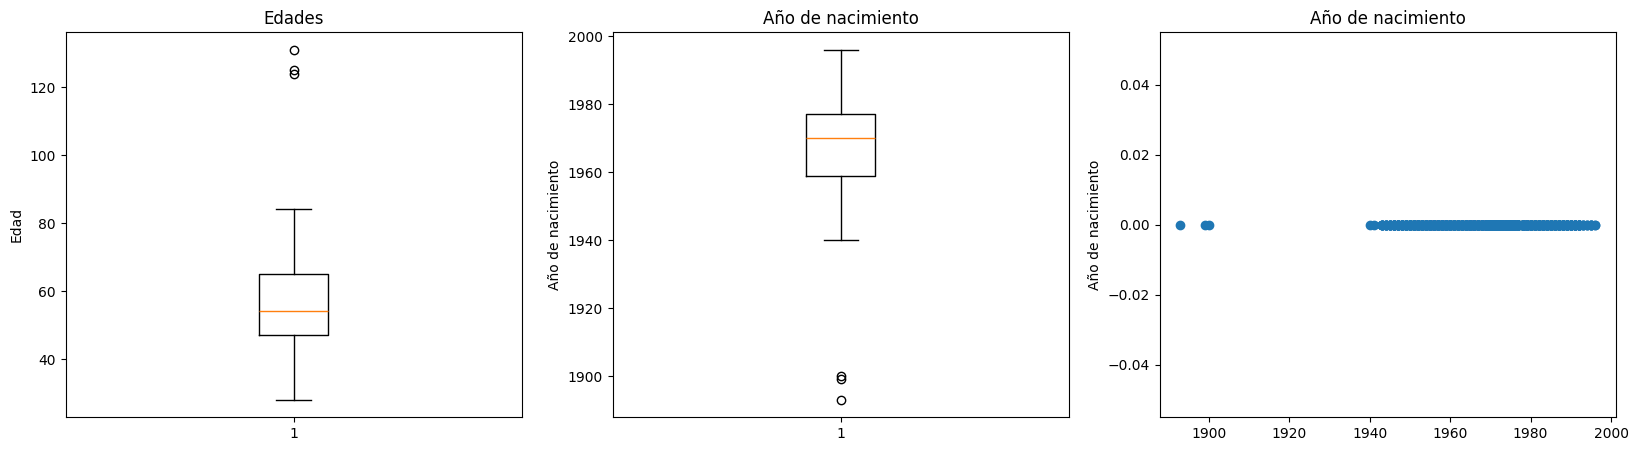

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].boxplot(clients_data['Age'])
ax[0].set_title('Edades')
ax[0].set_ylabel('Edad')
ax[1].boxplot(clients_data['Year_Birth'])
ax[1].set_title('Año de nacimiento')
ax[1].set_ylabel('Año de nacimiento')
ax[2].scatter(clients_data['Year_Birth'], np.zeros(len(clients_data['Year_Birth'])))
ax[2].set_title('Año de nacimiento')
ax[2].set_ylabel('Año de nacimiento')
plt.show()


Se pueden ver valores atipicos en las edades, pues hay registros que superan los 120 años, esto no tienen sentido alguno teniendo en cuenta que la esperanza de vida de los seres humanos alrededor del mundo es aproximadamente de 80 años,pero dichos valores atipicos superan con demasiado margen este valor, por ello, estos registros seran eliminados.

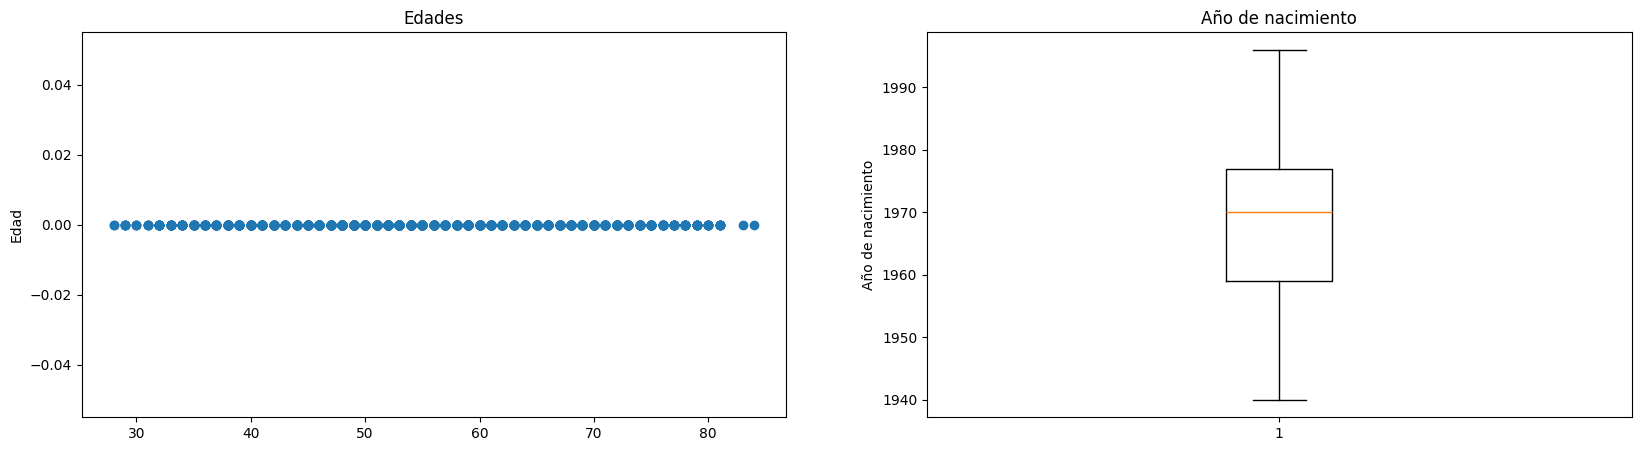

In [124]:
clients_data = clients_data[clients_data['Year_Birth'] > 1930]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(clients_data['Age'], np.zeros(len(clients_data['Age'])))
ax[0].set_title('Edades')
ax[0].set_ylabel('Edad')
ax[1].boxplot(clients_data['Year_Birth'])
ax[1].set_title('Año de nacimiento')
ax[1].set_ylabel('Año de nacimiento')
plt.show()

Con estas nuevas graficas podemos ver que ya no tenemos datos outliers que genere ruido en los datos a analizar, ademas podemos ver que el rango de edades estan entre un poco menos de los 30 años y un poco más de los 80 años, valores que nos permiten analizar mucho mejor el grupo demográfico al cual se le enfocara la campaña segun su edad.

### Educación

In [125]:
education_categories = clients_data['Education'].unique()

education_categories_order=[education_categories[3],education_categories[0],education_categories[4],education_categories[2],education_categories[1]]
education_categories_dict = dict(zip(education_categories_order, range(len(education_categories_order))))
print(education_categories_dict)

clients_data['Education'] = clients_data['Education'].map(education_categories_dict)

{'Basic': 0, 'Graduation': 1, '2n Cycle': 2, 'Master': 3, 'PhD': 4}


Para este atributo, se asiganron valores numéricos ordinales según el nivel de estudio de que se tiene en cada registro.

### Tiempo Afiliado

In [126]:
def contar_dias(desde_fecha):
    fecha_actual = datetime.now().date()
    fecha_desde = datetime.strptime(desde_fecha, '%d-%m-%Y').date()
    diferencia = fecha_actual - fecha_desde
    return diferencia.days

clients_data['Tiempo_afiliado'] = clients_data['Dt_Customer'].apply(contar_dias)
tmp = clients_data.pop('Tiempo_afiliado')
clients_data.insert(8, 'Tiempo_afiliado', tmp)
clients_data.drop(columns=['Dt_Customer'], inplace=True)

clients_data.drop(columns=['Year_Birth'], inplace=True)

Teniendo ya la fecha en la que se afilio cada persona a la compañia, se cambio esta este atributo por el número de días que el usuario lleva inscrito. De esta manera se medira mejor la antigüedad en el analisis.

### Campañas Aceptadas

In [127]:
accepted_campaigns= clients_data['AcceptedCmp1']+clients_data['AcceptedCmp2']+clients_data['AcceptedCmp3']+clients_data['AcceptedCmp4']+clients_data['AcceptedCmp5']+clients_data['Response']
clients_data.insert(20, 'Campañas_aceptadas', accepted_campaigns)
clients_data.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response'], inplace=True)

Al tener registros de la participación de cada usuario en las diferentes campañas, se sumaron las participaciones en todas las campañas para poder saber con que frecuencia el usuario se interesa en estas. Se creo una nueva columna con este dato y se eliminaron todas en las que se indicaba si participo o no en cada campaña.

### Ingresos

In [128]:
not_nan_income = clients_data['Income'].dropna()
prom_income = np.mean(not_nan_income)
clients_data['Income'] = clients_data['Income'].fillna(prom_income)

Se encontraron datos Nan en la fila de Ingresos de los usuarios, por ello se realizó imputación de datos hallando el promedio de los datos en este atributo y reemplazando los Nan por el valor para completar los datos de este atributo.

### número de hijos en casa

In [129]:
children = clients_data['Kidhome'] + clients_data['Teenhome']
clients_data.insert(4, 'Children', children)
clients_data.drop(columns=['Kidhome','Teenhome'], inplace=True)

Para reducir dimensionalidades y elimnarle ruido a los datos al momento de hacer el clustering se decido concatenar las columnas de # de niños y de número de deolecentes en casa, en una sola columnas que se el número de hijos que se tienen en casa, además de hacer un analisis más sencillo a nivel familia 

### lugares de compra preferido por el usuario

Para continuar con la reducción del ruido en el clustering se decidio reducir todas las compras por diferentes medio en una unica columna que incluya cual es el medio por el que más compra el cliente de entre web, catalogo y tienda. Tambien se agregara una segunda columna que incluya el total de compras en los tres medios 

In [130]:
total_purchases = clients_data['NumWebPurchases'] + clients_data['NumCatalogPurchases'] + clients_data['NumStorePurchases']
clients_data.insert(16, 'Total_purchases', total_purchases)

#get the place where the client makes more purchases

clients_data['Place'] = clients_data[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].idxmax(axis=1)
clients_data['Place'] = clients_data['Place'].replace({'NumWebPurchases':'Web','NumCatalogPurchases':'Catalog','NumStorePurchases':'Store'})
lugar = clients_data.pop('Place')
clients_data.insert(16, 'Place', lugar)

clients_data.drop(columns=['NumWebPurchases','NumCatalogPurchases','NumStorePurchases'], inplace=True)

In [131]:
clients_data.head(5)

,Education,Age,Marital_Status,Income,Children,Tiempo_afiliado,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,Place,Total_purchases,NumWebVisitsMonth,Campañas_aceptadas,Complain
0,1,67,0,58138.0,0,4238,58,635,88,546,172,88,88,3,Catalog,22,7,1,0
1,1,70,0,46344.0,2,3688,38,11,1,6,2,1,6,2,Store,4,5,0,0
2,1,59,1,71613.0,0,3887,26,426,49,127,111,21,42,1,Store,20,4,0,0
3,1,40,1,26646.0,1,3714,26,11,4,20,10,3,5,2,Store,6,6,0,0
4,4,43,1,58293.0,1,3736,94,173,43,118,46,27,15,5,Store,14,5,0,0


In [132]:
place_categories = clients_data['Place'].unique()
place_categories_dict = dict(zip(place_categories, range(len(place_categories))))
print(place_categories_dict)

clients_data['Place'] = clients_data['Place'].map(place_categories_dict)

{'Catalog': 0, 'Store': 1, 'Web': 2}


In [133]:
clients_data.head(5)

,Education,Age,Marital_Status,Income,Children,Tiempo_afiliado,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,Place,Total_purchases,NumWebVisitsMonth,Campañas_aceptadas,Complain
0,1,67,0,58138.0,0,4238,58,635,88,546,172,88,88,3,0,22,7,1,0
1,1,70,0,46344.0,2,3688,38,11,1,6,2,1,6,2,1,4,5,0,0
2,1,59,1,71613.0,0,3887,26,426,49,127,111,21,42,1,1,20,4,0,0
3,1,40,1,26646.0,1,3714,26,11,4,20,10,3,5,2,1,6,6,0,0
4,4,43,1,58293.0,1,3736,94,173,43,118,46,27,15,5,1,14,5,0,0


### Normalización

In [134]:

def normalize_data(data, columns):
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

columns = ['Education','Age','Marital_Status','Income', 'Children', 'Tiempo_afiliado', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
           'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'Place','Total_purchases', 'NumWebVisitsMonth', 'Campañas_aceptadas', 'Complain']
clients_data_normalized = clients_data.copy() 
clients_data_normalized = normalize_data(clients_data_normalized, columns)

Se normalizaron todos los datos para que la relación del tamaño de los datos no afecte de manera negativa el Clustering y por consiguiente el analisis de los datos que se realizara posteriormente.

## Clustering

### Kmeans

In [135]:
kmeans_results, metrics = kMeansClusteringValidation(clients_data_normalized, 10, 0.05,"Client Data")

columns_names = ["K Value", "Clusters"] + metrics + ["Min Number of Points"]
kmeans_df = pd.DataFrame(kmeans_results, columns=columns_names)
kmeans_df = kmeans_df.dropna(subset=["Beta CV"])
kmeans_df = kmeans_df.drop(kmeans_df.loc[kmeans_df["Min Number of Points"] < len(clients_data_normalized) * 0.10].index).reset_index(drop=True)

display(kmeans_df)

Iteraciones Kmeans- Client Data: 100%|██████████| 10/10 [02:00<00:00, 12.06s/it]


,K Value,Clusters,Beta CV,C Index,Normalized Cut,Dunn,Davies Bouldin,Silhouette,Min Number of Points
0,2.0,2.0,0.758043,0.151430,1.124105,0.365136,1.762871,0.031396,790.0
1,3.0,3.0,0.731895,0.150612,2.183261,0.077196,1.912994,0.018992,538.0
2,4.0,4.0,0.757278,0.210072,3.205214,0.058001,2.131040,-0.048604,435.0
3,5.0,5.0,0.747103,0.204602,4.227764,0.079871,2.059008,-0.294790,237.0
4,2.0,2.0,0.758043,0.151430,1.124105,0.365136,1.762871,0.031396,790.0
5,3.0,3.0,0.731676,0.150078,2.183086,0.077196,1.909673,0.011029,533.0
6,4.0,4.0,0.744521,0.190104,3.205099,0.069249,2.081552,-0.195264,352.0
7,5.0,5.0,0.713718,0.174212,4.236661,0.049319,2.220885,0.011093,292.0
8,2.0,2.0,0.758043,0.151430,1.124105,0.365136,1.762871,0.031396,790.0
9,3.0,3.0,0.730835,0.148438,2.182890,0.105537,1.905199,-0.002517,524.0


#### Cálculo de Mejores Resultados por Métrica

In [136]:
kmeans_best_betacv=kmeans_df.sort_values(by=["Beta CV"],ascending=True).head(10)[["K Value","Clusters","Beta CV"]]

kmeans_best_cindex=kmeans_df.sort_values(by=["C Index"],ascending=True).head(10)[["K Value","Clusters","C Index"]]

kmeans_df['Distancia'] = abs(kmeans_df['Normalized Cut'] - kmeans_df['Clusters'])
kmeans_best_nc=kmeans_df.sort_values(by='Distancia', ascending=True).head(10)[["K Value","Clusters", "Normalized Cut"]]

kmeans_best_dunn=kmeans_df.sort_values(by=["Dunn"],ascending=False).head(10)[["K Value","Clusters","Dunn"]]

kmeans_best_dv=kmeans_df.sort_values(by=["Davies Bouldin"],ascending=True).head(10)[["K Value","Clusters","Davies Bouldin"]]

kmeans_best_sil=kmeans_df.sort_values(by=["Silhouette"],ascending=False).head(10)[["K Value","Clusters","Silhouette"]]

list_df_kmeans=[kmeans_best_betacv,kmeans_best_cindex,kmeans_best_nc,kmeans_best_dunn,kmeans_best_dv,kmeans_best_sil]

#### Graficación

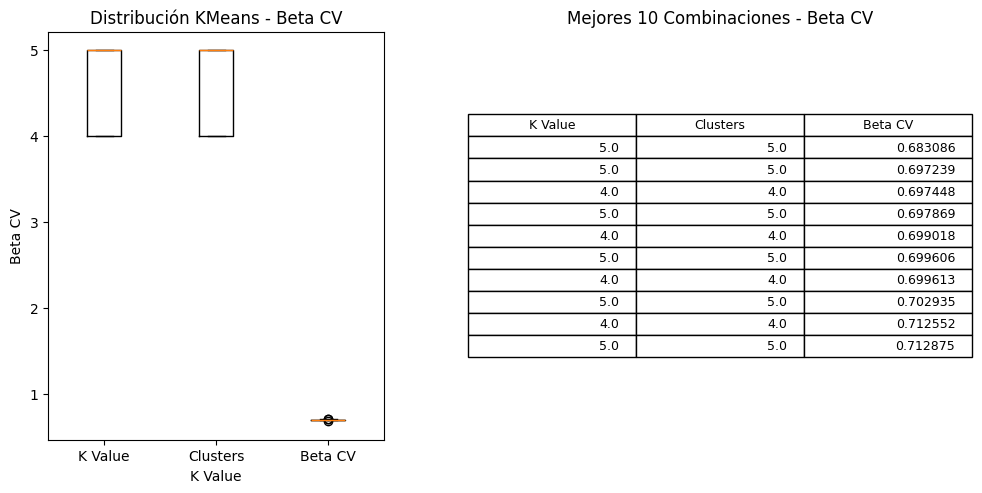

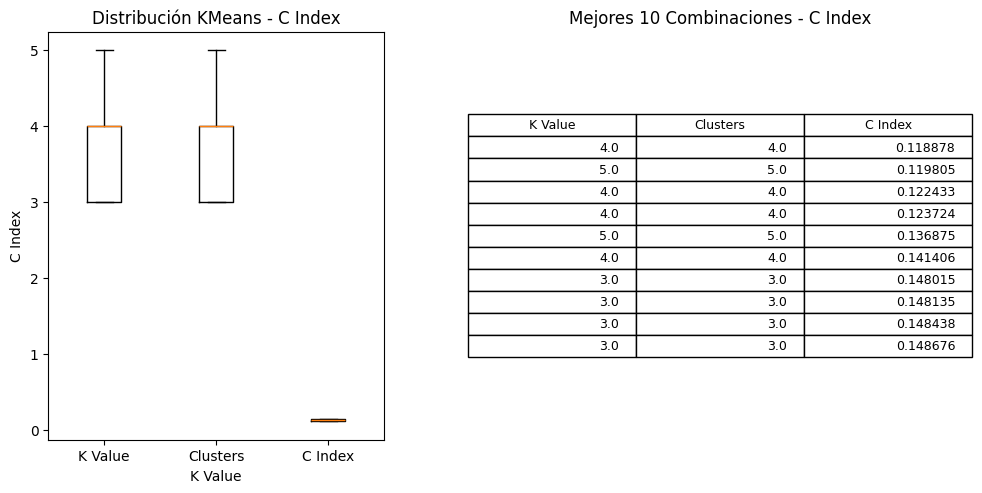

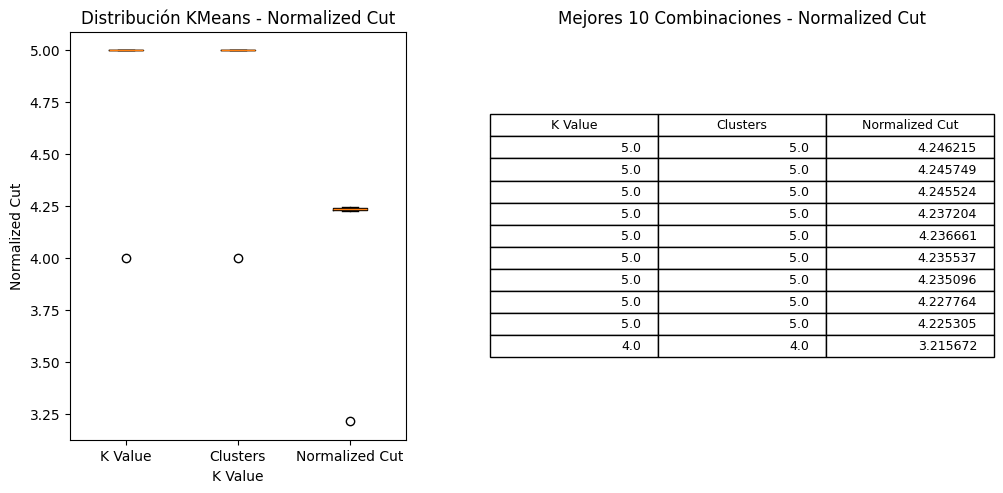

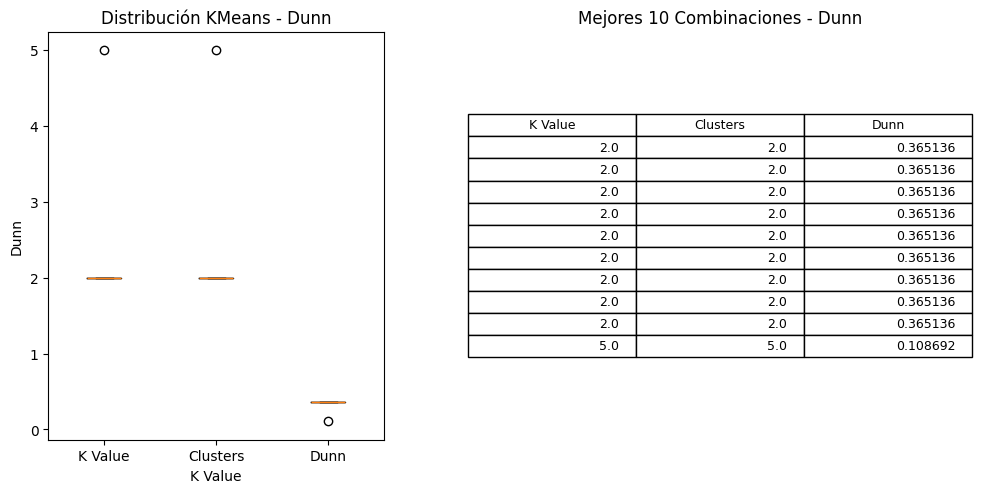

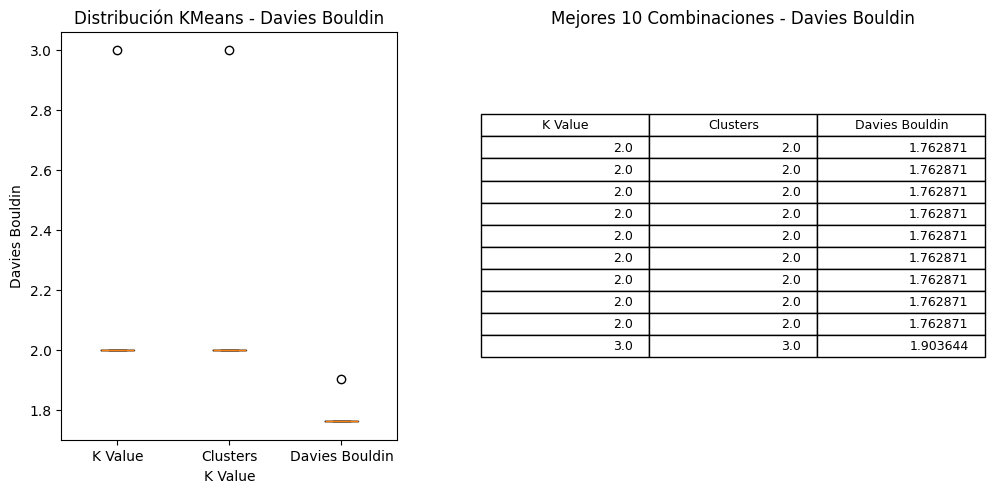

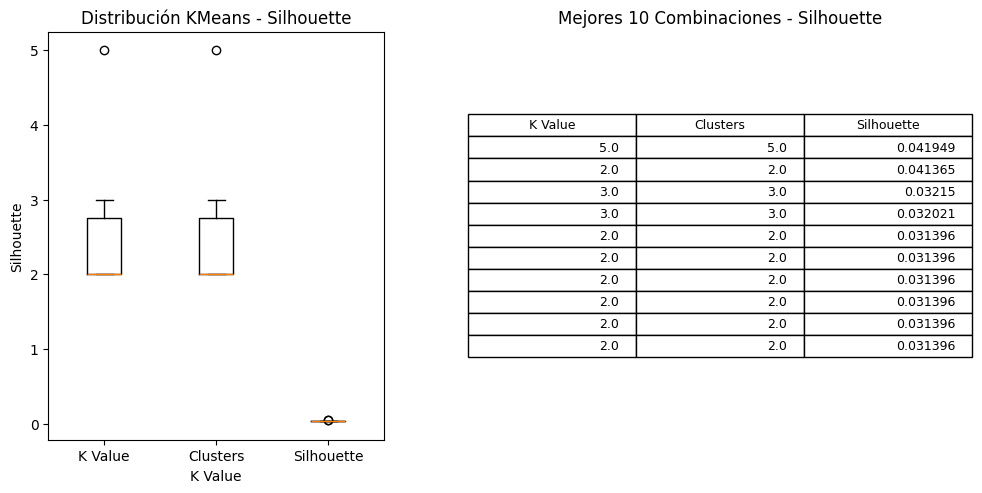

In [137]:
for i, metric in enumerate(metrics):
    graphKMeans(kmeans_df,list_df_kmeans[i].round(6),metric)

Con estas graficas determinamos que una de las mejores metricas para obtener posibles candidatos a usar con el metodo de clustering k-means esta entre davies-bouldin y Dunn index, como deseamos priorizar la separabilidad de los datos para poder tener una vizualización mucho más analizable escogimos Dunn index para repetir k-means por 40 iteraciones y obtener el mejor para cada dimensionalidad posible y asi vizualizarlo 

In [139]:
dataframe_PCA2D = PCA(clients_data_normalized,2)
dataframe_PCA3D = PCA(clients_data_normalized,3)


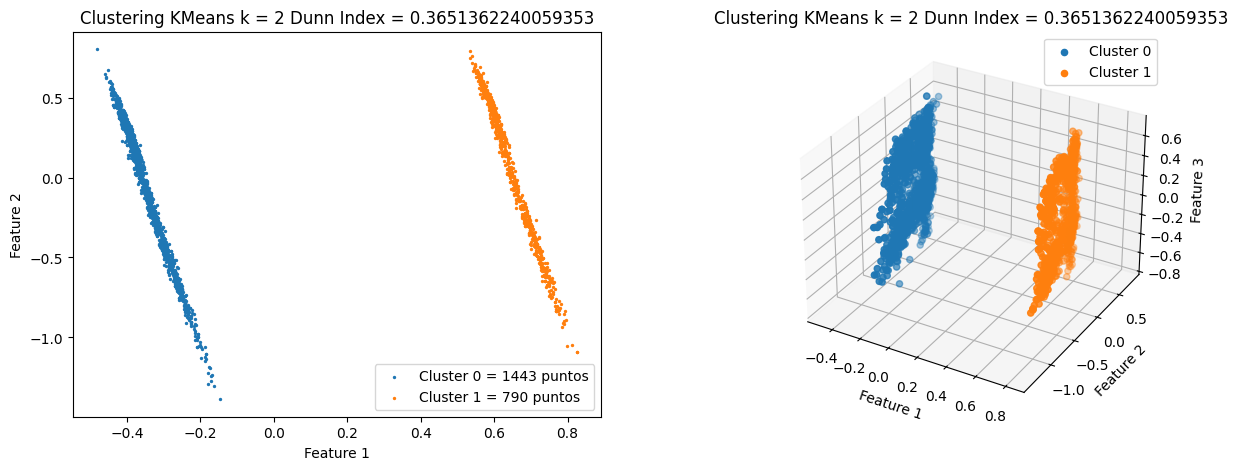

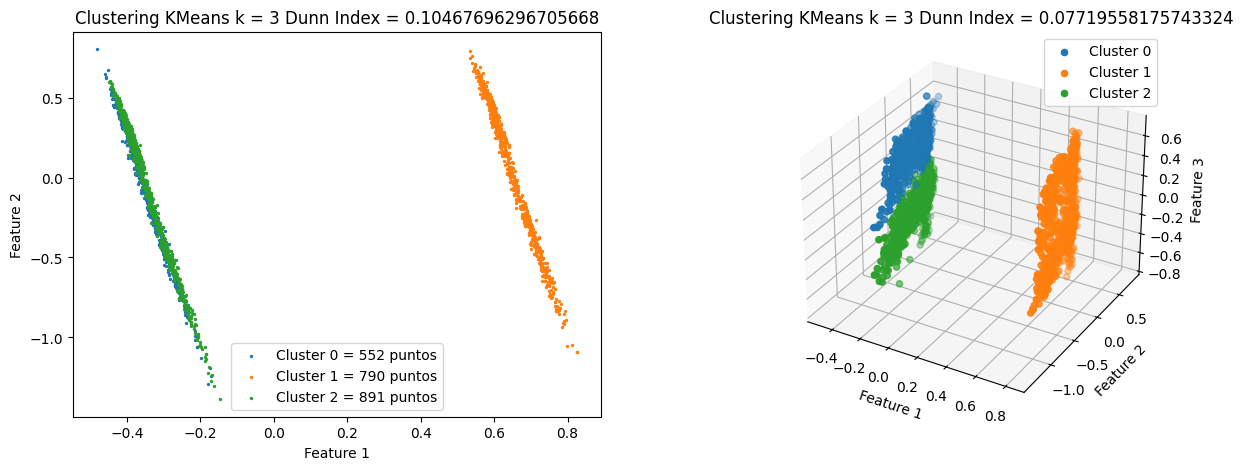

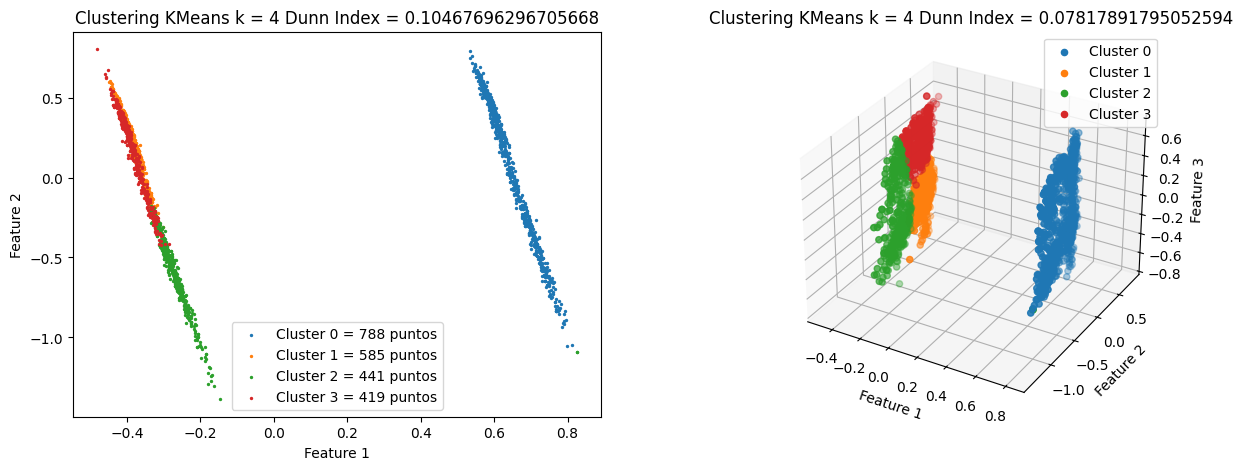

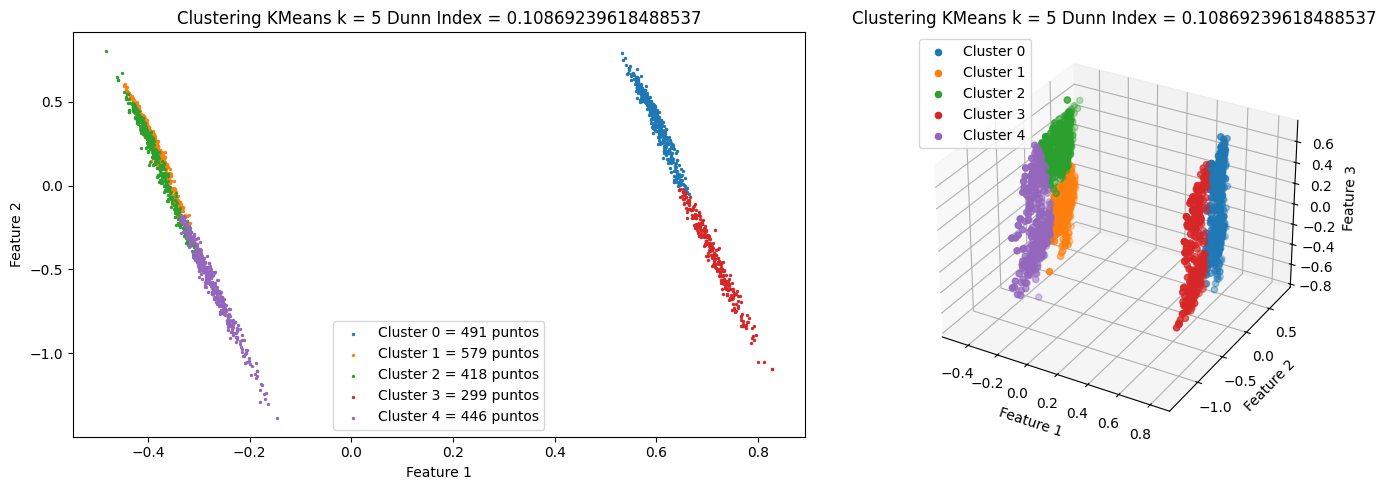

In [142]:
warnings.filterwarnings("ignore")

k_means_values = [2, 3, 4, 5]
iterations = 40

best_clustering_kmeans = {}

for k in k_means_values:
    best_dunn_index_value = float('-inf')
    best_model =  None

    for i in range(iterations):
        kmeans = KMeans(n_clusters=k)
        C = kmeans.fit_predict(clients_data_normalized)
        dunn_index = getDunn(clients_data_normalized, C)
        if dunn_index > best_dunn_index_value:
            best_dunn_index_value = dunn_index
            best_model = C

    best_clustering_kmeans[k] = {"model": best_model, "dunn_index": best_dunn_index_value}

    unique_clusters, counts = np.unique(best_model, return_counts=True)

#visualización de los clusters en 2D

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for cluster_label in unique_clusters:
        plt.scatter(dataframe_PCA2D[best_model == cluster_label, 0], dataframe_PCA2D[best_model == cluster_label, 1], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=2)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Clustering KMeans k = ' + str(k) + ' Dunn Index = ' + str(best_dunn_index_value))
    plt.legend()

#visualización de los clusters en 3D

    ax = plt.subplot(1, 2, 2, projection='3d')

    for cluster_label in unique_clusters:
        ax.scatter(dataframe_PCA3D[best_model == cluster_label, 0], dataframe_PCA3D[best_model == cluster_label, 1], dataframe_PCA3D[best_model == cluster_label, 2], label=f'Cluster {cluster_label}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title('Clustering KMeans k = ' + str(k) + ' Dunn Index = ' + str(dunn_index))
    ax.legend()

plt.tight_layout()
plt.show()


### DBSCAN

#### Rangos de MIN_PTS y EPSILON

In [92]:
minpts_values=[5,10,15,20,25,30,35,40,45]
epsilon_values=[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.3]
warnings.filterwarnings("ignore", category=RuntimeWarning)
parameter_combinations = list(itertools.product(minpts_values,epsilon_values*3))
dbscan_results,metrics=DBSCANClusteringValidation(clients_data_normalized, parameter_combinations,"Client Data")
columns_names=["Min_Pts", "Epsilon", "Clusters"]+metrics+["Min Number of Points"]
dbscan_df=pd.DataFrame(dbscan_results,columns=columns_names)
dbscan_df=dbscan_df.dropna(subset=["Beta CV"])
dbscan_df=dbscan_df.drop(dbscan_df.loc[dbscan_df["Clusters"]<2].index)
dbscan_df=dbscan_df.drop(dbscan_df.loc[dbscan_df["Min Number of Points"]<len(clients_data_normalized)*0.10].index)
dbscan_df=dbscan_df.drop(dbscan_df.loc[dbscan_df["Clusters"]>5].index).reset_index(drop=True)
display(dbscan_df)

Configuraciones DBSCAN- Client Data:   0%|          | 0/180 [00:00<?, ?it/s]

Configuraciones DBSCAN- Client Data: 100%|██████████| 180/180 [07:06<00:00,  2.37s/it]


,Min_Pts,Epsilon,Clusters,Beta CV,C Index,Normalized Cut,Dunn,Davies Bouldin,Silhouette,Min Number of Points
0,5.0,0.7,2.0,0.731197,0.119756,2.136332,0.069865,2.647620,-0.612366,701.0
1,5.0,0.8,2.0,0.742467,0.130507,2.128977,0.207441,3.130651,-0.842488,757.0
2,5.0,0.7,2.0,0.731197,0.119756,2.136332,0.069865,2.647620,-0.612366,701.0
3,5.0,0.8,2.0,0.742467,0.130507,2.128977,0.207441,3.130651,-0.842488,757.0
4,10.0,0.7,2.0,0.724888,0.114654,2.143344,0.069865,2.411856,-0.468189,667.0
5,10.0,0.8,2.0,0.740190,0.127706,2.130349,0.172595,2.957442,-0.807917,746.0
6,10.0,0.9,2.0,0.748304,0.138230,2.127406,0.266079,3.142238,-0.903112,770.0
7,10.0,0.7,2.0,0.724888,0.114654,2.143344,0.069865,2.411856,-0.468189,667.0
8,10.0,0.8,2.0,0.740190,0.127706,2.130349,0.172595,2.957442,-0.807917,746.0
9,10.0,0.9,2.0,0.748304,0.138230,2.127406,0.266079,3.142238,-0.903112,770.0


#### Cálculo de Mejores Resultados por Métrica

In [89]:
dbscan_best_betacv=dbscan_df.sort_values(by=["Beta CV"],ascending=True).head(10)[["Min_Pts","Epsilon","Clusters","Beta CV"]]

dbscan_best_cindex=dbscan_df.sort_values(by=["C Index"],ascending=True).head(10)[["Min_Pts","Epsilon","Clusters","C Index"]]

dbscan_df['Distancia'] = abs(dbscan_df['Normalized Cut'] - dbscan_df['Clusters'])
dbscan_best_nc = dbscan_df.sort_values(by='Distancia', ascending=True).head(10)[["Min_Pts", "Epsilon", "Clusters", "Normalized Cut"]]

dbscan_best_dunn=dbscan_df.sort_values(by=["Dunn"],ascending=False).head(10)[["Min_Pts","Epsilon","Clusters","Dunn"]]

dbscan_best_dv=dbscan_df.sort_values(by=["Davies Bouldin"],ascending=True).head(10)[["Min_Pts","Epsilon","Clusters","Davies Bouldin"]]

dbscan_best_sil=dbscan_df.sort_values(by=["Silhouette"],ascending=False).head(10)[["Min_Pts","Epsilon","Clusters","Silhouette"]]

list_df_dbscan=[dbscan_best_betacv,dbscan_best_cindex,dbscan_best_nc,dbscan_best_dunn,dbscan_best_dv,dbscan_best_sil]

#### Graficación

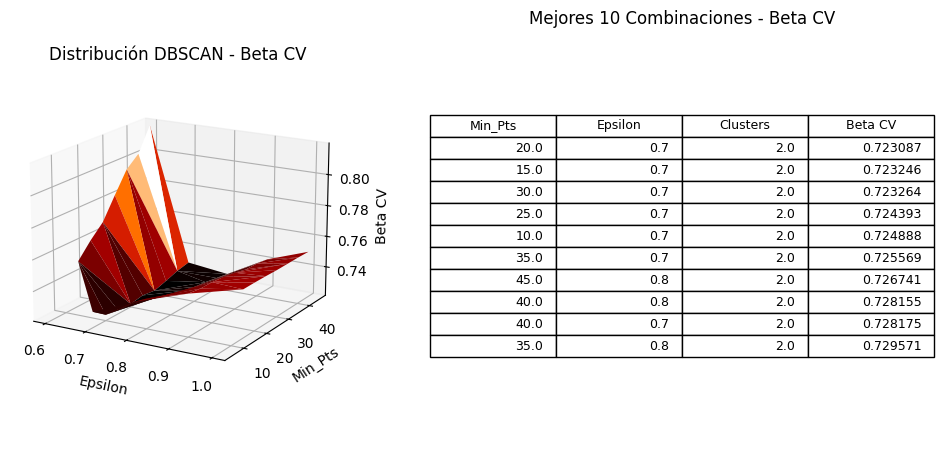

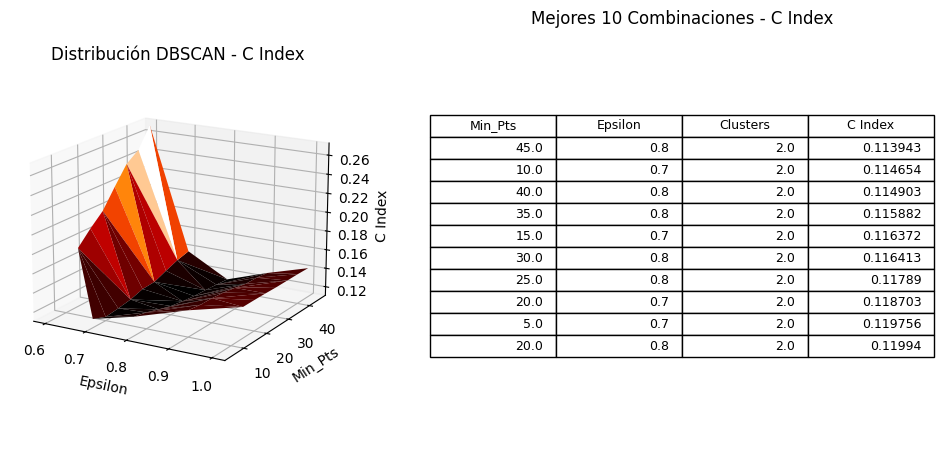

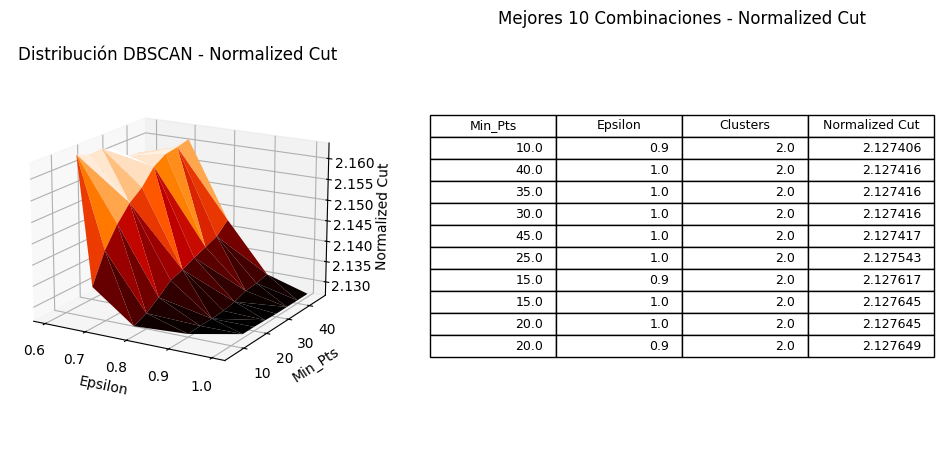

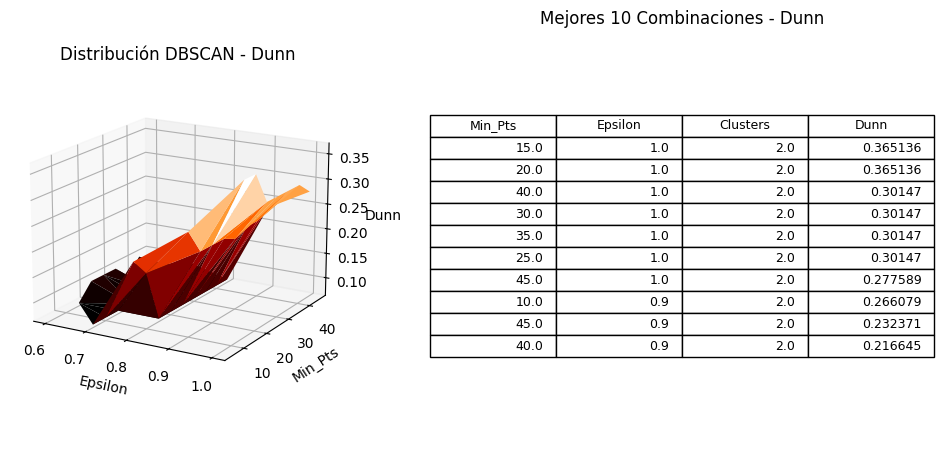

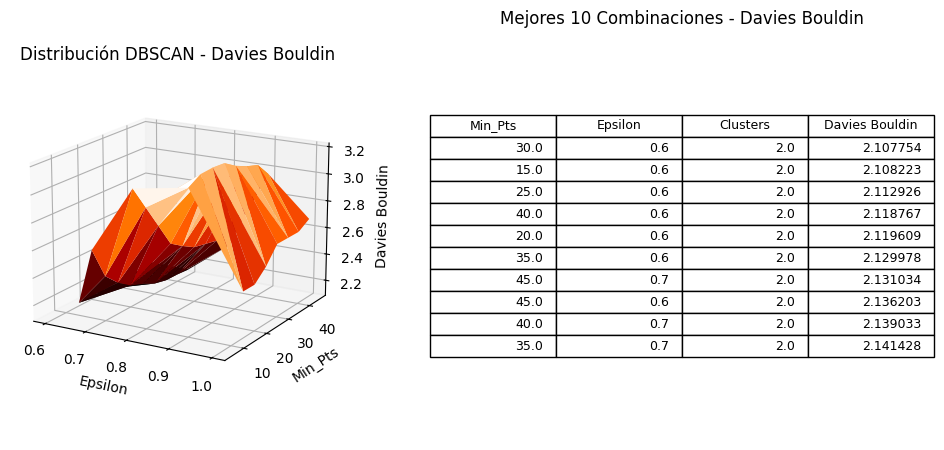

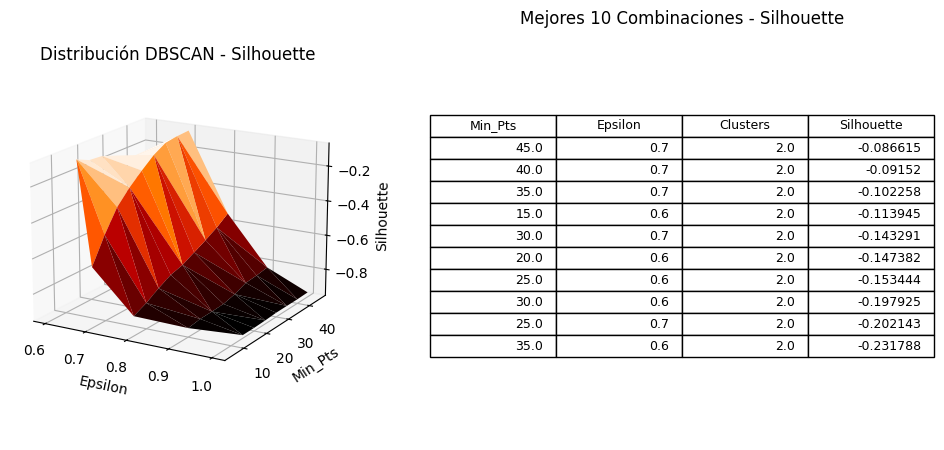

In [90]:
for i, metric in enumerate(metrics):
    graphDBSCAN(dbscan_df,list_df_dbscan[i].round(6),metric)